In [ ]:
! pip install osmnx

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, LineString
import osmnx as ox
from scipy.spatial import KDTree

In [3]:
###USING DATASET CONTAINING POLYGONS FOR 15 BELGIAN CITIES

cities = gpd.read_file('Belgium Urban Polygons/BE_STATBEL_SH_SU_UA_CITY/BE_STATBEL_SH_SU_UA_CITY_2019_v60.gpkg')
cities.head(15)

OBJECTID  CityCod                            CityName          NameLg  \
0          1  BE001K1  Bruxelles / Brussel (greater city)  French / Dutch   
1          2  BE002C1                           Antwerpen           Dutch   
2          3  BE003C1                                Gent           Dutch   
3          4  BE004K1            Charleroi (greater city)          French   
4          5  BE005K1                Liège (greater city)          French   
5          6  BE006C1                              Brugge           Dutch   
6          7  BE007C1                               Namur          French   
7          8  BE008C1                              Leuven           Dutch   
8          9  BE009K1                 Mons (greater city)          French   
9         10  BE010C1                            Kortrijk           Dutch   
10        11  BE011C1                            Oostende           Dutch   
11        12  BE012C1                            Mechelen           Dutch   
12        13  BE013C1                            Mouscron          French   
13        14  BE014K1          La Louvière (greater city)          French   
14        15  BE015K1             Verviers (greater city)          French   

   CntryCod      hm²_3812      hm²_3035   ValidFrom ValidTo  \
0        BE  16242.379883  16244.017619  2019-01-01    None   
1        BE  20442.529297  20441.663268  2019-01-01    None   
2        BE  15774.230469  15774.773400  2019-01-01    None   
3        BE  13030.849609  13032.581282  2019-01-01    None   
4        BE  21262.189453  21264.940140  2019-01-01    None   
5        BE  14090.059570  14089.551774  2019-01-01    None   
6        BE  17589.369141  17591.733537  2019-01-01    None   
7        BE   5750.669922   5751.191709  2019-01-01    None   
8        BE  19859.839844  19862.492881  2019-01-01    None   
9        BE   8070.009766   8070.873288  2019-01-01    None   
10       BE   4095.780029   4095.708565  2019-01-01    None   
11       BE   6578.560059   6578.888681  2019-01-01    None   
12       BE   4061.919922   4062.404920  2019-01-01    None   
13       BE   8395.530273   8396.660336  2019-01-01    None   
14       BE   4697.779785   4698.405769  2019-01-01    None   

                                             geometry  
0   POLYGON ((3928036.995 3104107.121, 3928097.982...  
1   POLYGON ((3929589.925 3130550.761, 3929534.154...  
2   POLYGON ((3879958.364 3115443.764, 3879929.944...  
3   POLYGON ((3928292.279 3056880.731, 3928236.835...  
4   POLYGON ((4003367.451 3077447.518, 4003384.637...  
5   POLYGON ((3847095.024 3139132.440, 3847063.082...  
6   POLYGON ((3959980.283 3043151.247, 3959959.175...  
7   POLYGON ((3951010.216 3094541.009, 3951000.747...  
8   POLYGON ((3894754.771 3061637.270, 3894953.953...  
9   POLYGON ((3842883.197 3094434.015, 3842874.414...  
10  POLYGON ((3821386.766 3145737.869, 3821499.368...  
11  POLYGON ((3937269.683 3112246.341, 3937011.965...  
12  POLYGON ((3844675.024 3088818.314, 3844674.807...  
13  POLYGON ((3910617.849 3060928.612, 3910685.311...  
14  POLYGON ((4029991.159 3066190.741, 4029991.244...

In [4]:
# Only keeping some of the cities
objectid_list = [1, 2, 3, 4, 5, 6, 8, 11]  
cities = cities[cities['OBJECTID'].isin(objectid_list)]

city_name_mapping = {
    'Bruxelles / Brussel (greater city)': 'Brussels',
    'Charleroi (greater city)': 'Charleroi',
    'Liège (greater city)': 'Liege'
}

cities['CityName'] = cities['CityName'].replace(city_name_mapping)
cities.head(10)

OBJECTID  CityCod   CityName          NameLg CntryCod      hm²_3812  \
0          1  BE001K1   Brussels  French / Dutch       BE  16242.379883   
1          2  BE002C1  Antwerpen           Dutch       BE  20442.529297   
2          3  BE003C1       Gent           Dutch       BE  15774.230469   
3          4  BE004K1  Charleroi          French       BE  13030.849609   
4          5  BE005K1      Liege          French       BE  21262.189453   
5          6  BE006C1     Brugge           Dutch       BE  14090.059570   
7          8  BE008C1     Leuven           Dutch       BE   5750.669922   
10        11  BE011C1   Oostende           Dutch       BE   4095.780029   

        hm²_3035   ValidFrom ValidTo  \
0   16244.017619  2019-01-01    None   
1   20441.663268  2019-01-01    None   
2   15774.773400  2019-01-01    None   
3   13032.581282  2019-01-01    None   
4   21264.940140  2019-01-01    None   
5   14089.551774  2019-01-01    None   
7    5751.191709  2019-01-01    None   
10   4095.708565  2019-01-01    None   

                                             geometry  
0   POLYGON ((3928036.995 3104107.121, 3928097.982...  
1   POLYGON ((3929589.925 3130550.761, 3929534.154...  
2   POLYGON ((3879958.364 3115443.764, 3879929.944...  
3   POLYGON ((3928292.279 3056880.731, 3928236.835...  
4   POLYGON ((4003367.451 3077447.518, 4003384.637...  
5   POLYGON ((3847095.024 3139132.440, 3847063.082...  
7   POLYGON ((3951010.216 3094541.009, 3951000.747...  
10  POLYGON ((3821386.766 3145737.869, 3821499.368...

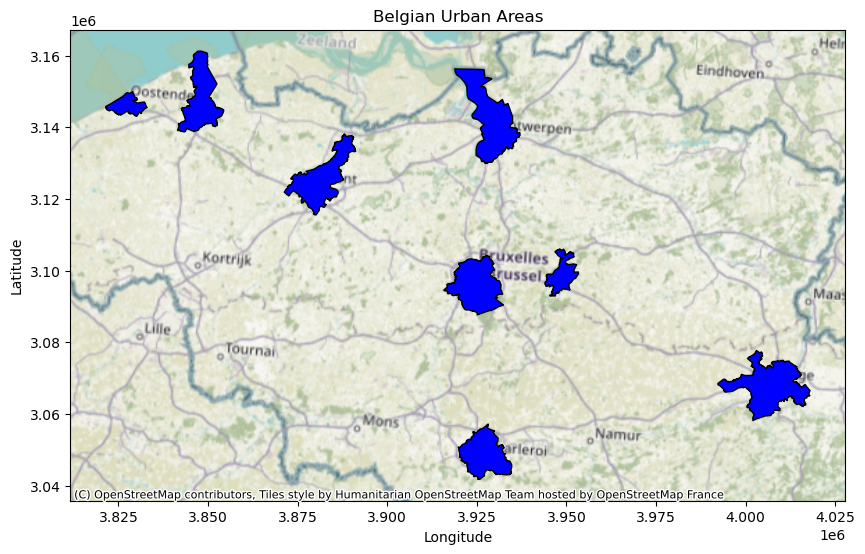

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
cities.plot(ax=ax, color='blue', edgecolor='black')

# Add basemap
ctx.add_basemap(ax, crs=cities.crs.to_string())

ax.set_title('Belgian Urban Areas')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


In [6]:
##SETTING THE CRS CORRECTLY

if cities.crs is None or cities.crs.to_string() != 'EPSG:4326':
    cities = cities.to_crs(epsg=4326)

# Verify the CRS
print(cities.crs)

EPSG:4326


In [7]:
# Function to obtain all streets in urban polygons using open street map
def get_streets_within_polygon(polygon):
    bbox = polygon.bounds
    # Fetch streets within the bounding box
    streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')
    # Convert the graph to a GeoDataFrame
    streets_gdf = ox.graph_to_gdfs(streets, nodes=False, edges=True)
    # Filter streets in the bounding box to only those within the polygon
    streets_within_polygon = streets_gdf[streets_gdf.intersects(polygon)]
    return streets_within_polygon

# Function to sample points from streets
def sample_points_on_streets(edges, num_points=4):
    sampled_points = []
    for _, row in edges.iterrows():
        line = row.geometry
        if isinstance(line, LineString):
            length = line.length
            distances = np.linspace(0, length, num_points)
            points = [line.interpolate(distance) for distance in distances]
            sampled_points.extend(points)
    return sampled_points

def remove_close_points(gdf, min_distance):
    # Convert the GeoDataFrame to a numpy array of coordinates
    coords = np.array([[point.x, point.y] for point in gdf.geometry])
    
    # Build a KDTree for fast spatial indexing
    tree = KDTree(coords)
    
    # Find pairs of points within the specified minimum distance
    pairs = tree.query_pairs(min_distance)
    
    # Create a set to track points to keep
    to_keep = set(range(len(gdf)))
    
    for i, j in pairs:
        # Keep the first point and remove the second point in each pair
        if j in to_keep:
            to_keep.remove(j)
    
    # Filter the GeoDataFrame to keep only the required points
    filtered_gdf = gdf.iloc[list(to_keep)]
    
    return filtered_gdf



/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


688878
10333
5775


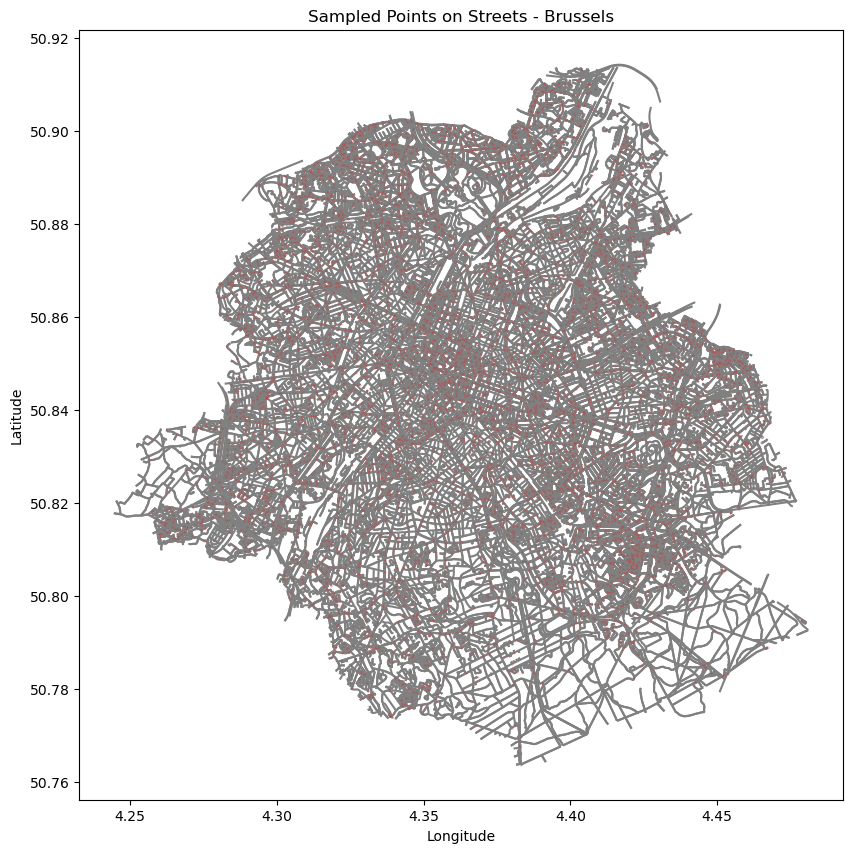

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


248709
3731
2705


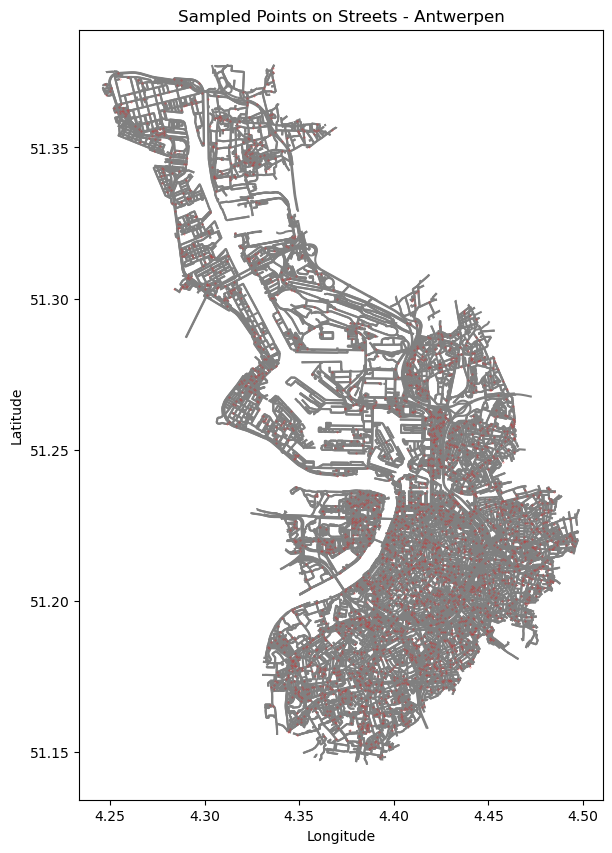

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


228624
3429
2433


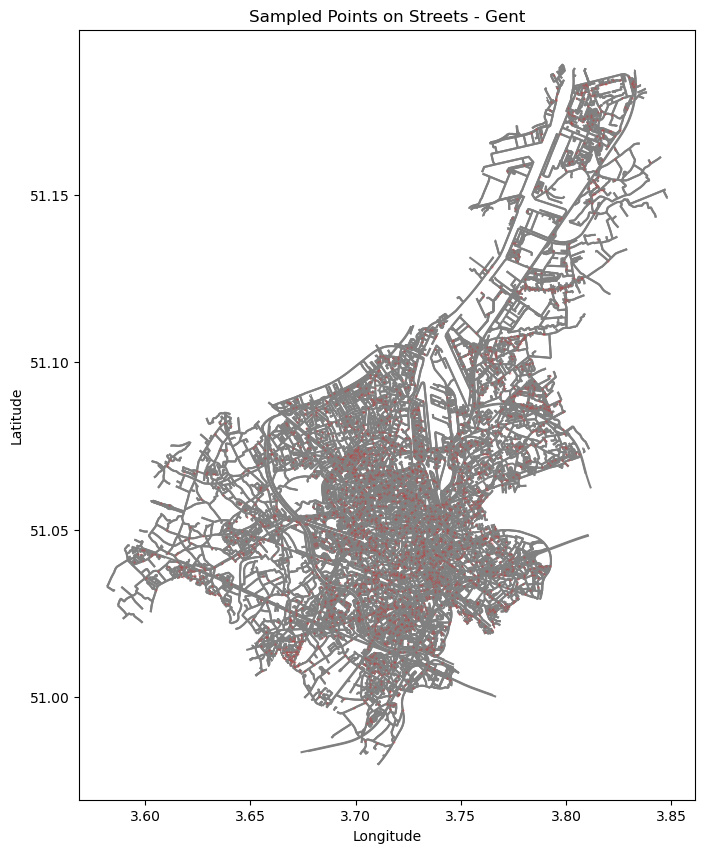

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


117189
1758
1437


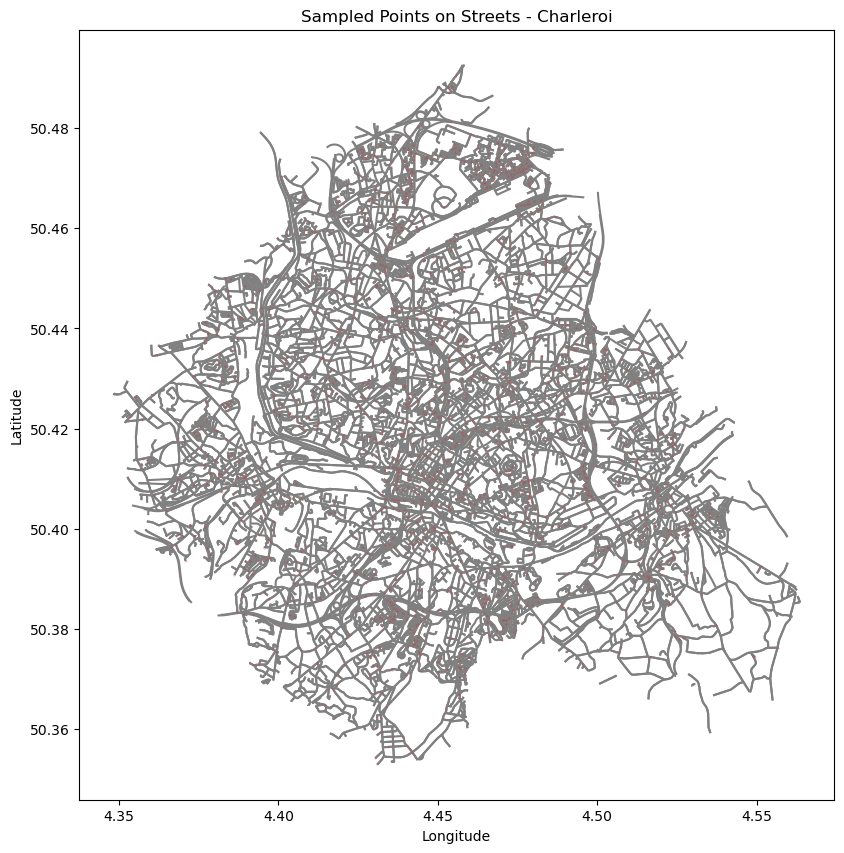

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


234111
3512
2725


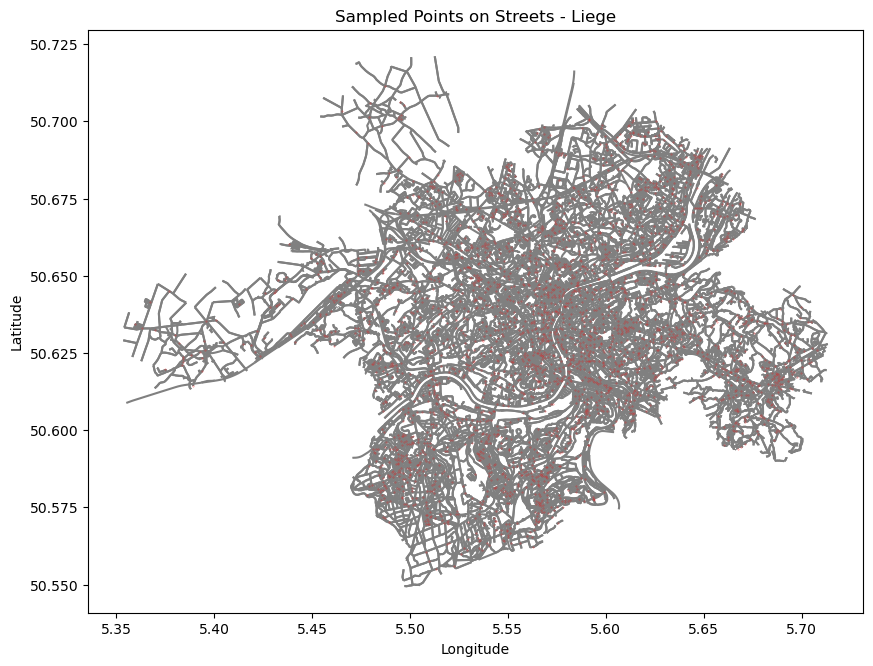

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


154599
2319
1723


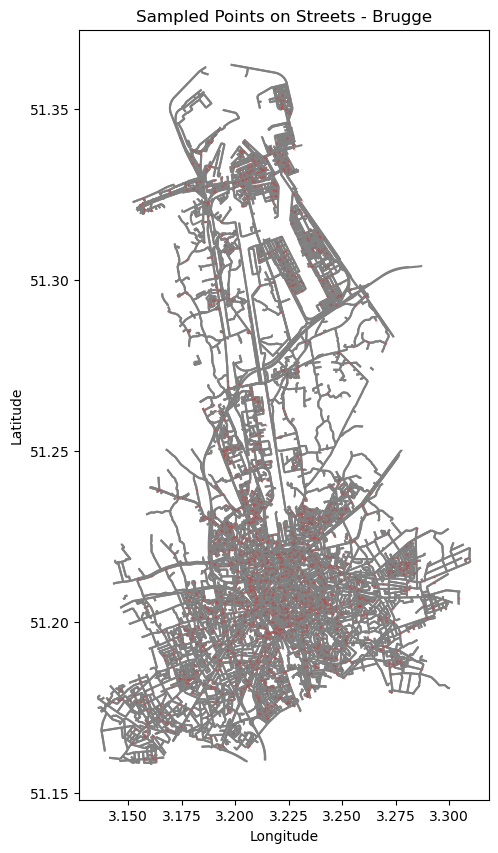

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


130215
1953
1274


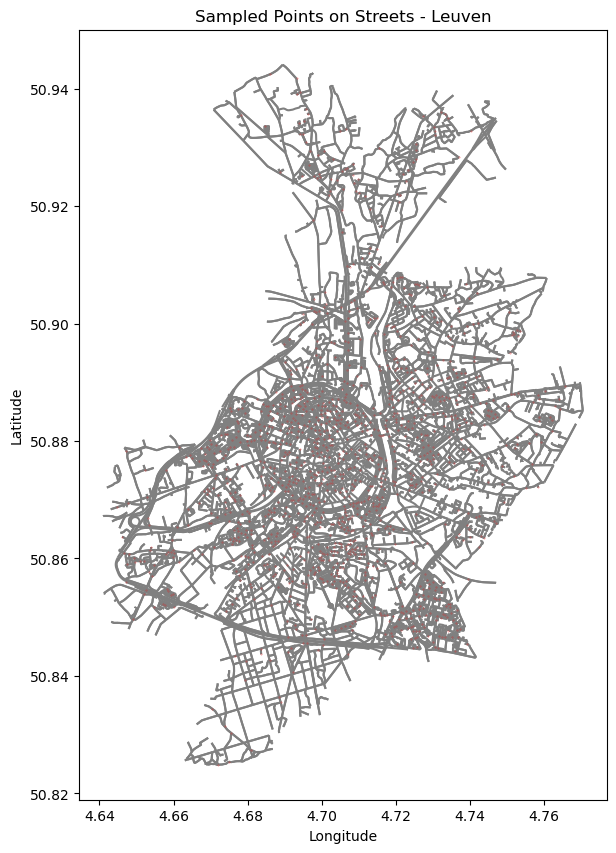

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


55035
826
629


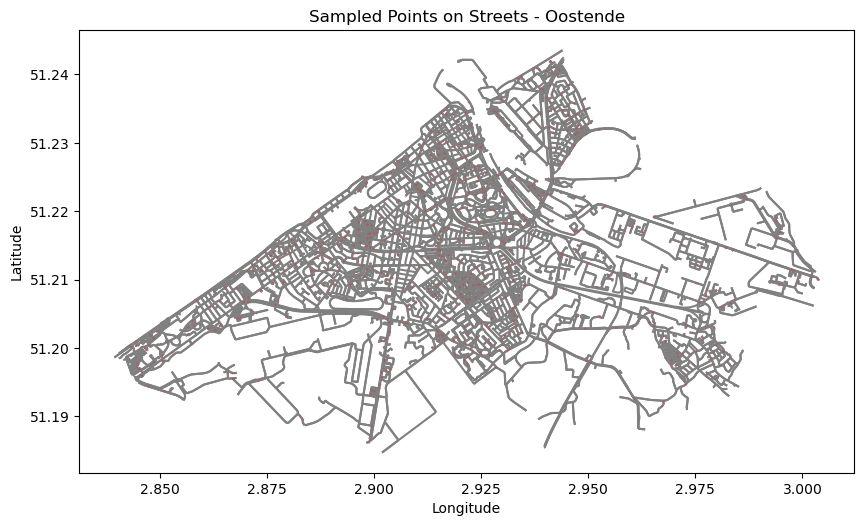

In [8]:
# Iterate over each city
for city_name, city_polygon in cities[['CityName', 'geometry']].values:
    # Name the polygon object according to the city
    exec(f"{city_name.lower()}_polygon = city_polygon")
    
    # Fetch streets within the city polygon and name the object accordingly
    streets = get_streets_within_polygon(city_polygon)
    exec(f"{city_name.lower()}_streets = streets")
    
    # Sample points on the streets and name the object accordingly
    points = sample_points_on_streets(streets, num_points=3)
    exec(f"{city_name.lower()}_points = points")
    
    # Convert points to a GeoDataFrame and name the object accordingly
    new_aeds = gpd.GeoDataFrame(geometry=points, crs=streets.crs)
    exec(f"{city_name.lower()}_new_aeds = new_aeds")
    print(len(new_aeds))
    
    # Randomly sample 1.5% of the coordinates
    new_aeds = new_aeds.sample(frac=0.015, random_state=42)
    exec(f"{city_name.lower()}_new_aeds = new_aeds")
    print(len(new_aeds))
    
    ###removing points roughly within 50m of each other
    new_aeds = remove_close_points(new_aeds, min_distance=0.0005)
    exec(f"{city_name}_new_aeds = new_aeds")
    print(len(new_aeds))
    
    ##Save new possible aed locations as csv
    new_aeds.to_csv(f'Data/{city_name}_new_aeds.csv', index=False)
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 10))
    streets.plot(ax=ax, color='gray', zorder=1)
    new_aeds.plot(ax=ax, color='red', markersize=.07, zorder=2, alpha=.6)
    
    ax.set_title(f'Sampled Points on Streets - {city_name}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()


In [9]:
##Reading in the clean data
aeds = gpd.read_file('Data/aeds.csv')
cards = gpd.read_file('Data/cards.csv')
vehicles = gpd.read_file('Data/vehicles.csv')

In [10]:
aeds['latitude'] = pd.to_numeric(aeds['latitude'], errors='coerce')
aeds['longitude'] = pd.to_numeric(aeds['longitude'], errors='coerce')

cards['latitude'] = pd.to_numeric(cards['latitude'], errors='coerce')
cards['longitude'] = pd.to_numeric(cards['longitude'], errors='coerce')

vehicles['latitude'] = pd.to_numeric(vehicles['latitude'], errors='coerce')
vehicles['longitude'] = pd.to_numeric(vehicles['longitude'], errors='coerce')

In [11]:
def filter_points_within_polygon(points, polygon, lat_column='latitude', lon_column='longitude'):
    # Create a Shapely Point geometry column from latitude and longitude
    points['geometry'] = gpd.points_from_xy(points[lon_column], points[lat_column])
    
    # Convert the points DataFrame to a GeoDataFrame
    gdf_points = gpd.GeoDataFrame(points, geometry='geometry')
    
    # Filter points within the polygon
    filtered_points = gdf_points[gdf_points.geometry.within(polygon)]
    
    return filtered_points

##Creating aed, card and vehicle datasets for each city
for city_name, city_polygon in cities[['CityName', 'geometry']].values:
    #aeds
    city_aeds = filter_points_within_polygon(aeds, city_polygon)
    print(f"Number of AEDs in {city_name}: {len(city_aeds)}")
    city_aeds.to_csv(f'Data/{city_name}_aeds.csv', index=False)
    
    #cards
    city_cards = filter_points_within_polygon(cards, city_polygon)
    print(f"Number of cards in {city_name}: {len(city_cards)}")
    city_cards.to_csv(f'Data/{city_name}_cards.csv', index=False)
    
    #vehicles
    city_vehicles = filter_points_within_polygon(vehicles, city_polygon)
    print(f"Number of vehicles in {city_name}: {len(city_vehicles)}")
    city_vehicles.to_csv(f'Data/{city_name}_vehicles.csv', index=False)


Number of AEDs in Brussels: 2024
Number of cards in Brussels: 10072
Number of vehicles in Brussels: 25
Number of AEDs in Antwerpen: 722
Number of cards in Antwerpen: 4053
Number of vehicles in Antwerpen: 18
Number of AEDs in Gent: 389
Number of cards in Gent: 2374
Number of vehicles in Gent: 10
Number of AEDs in Charleroi: 365
Number of cards in Charleroi: 2803
Number of vehicles in Charleroi: 8
Number of AEDs in Liege: 686
Number of cards in Liege: 3584
Number of vehicles in Liege: 15
Number of AEDs in Brugge: 161
Number of cards in Brugge: 825
Number of vehicles in Brugge: 4
Number of AEDs in Leuven: 167
Number of cards in Leuven: 783
Number of vehicles in Leuven: 8
Number of AEDs in Oostende: 69
Number of cards in Oostende: 713
Number of vehicles in Oostende: 2


/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


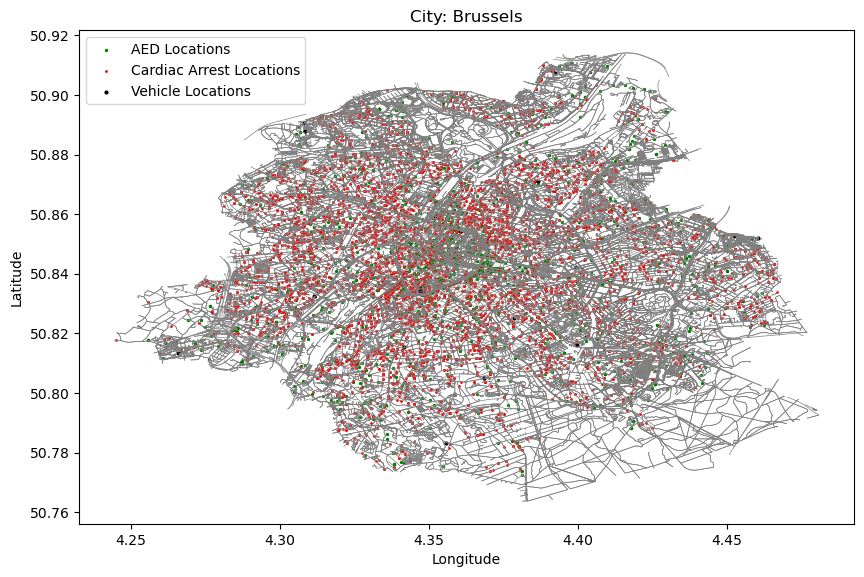

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


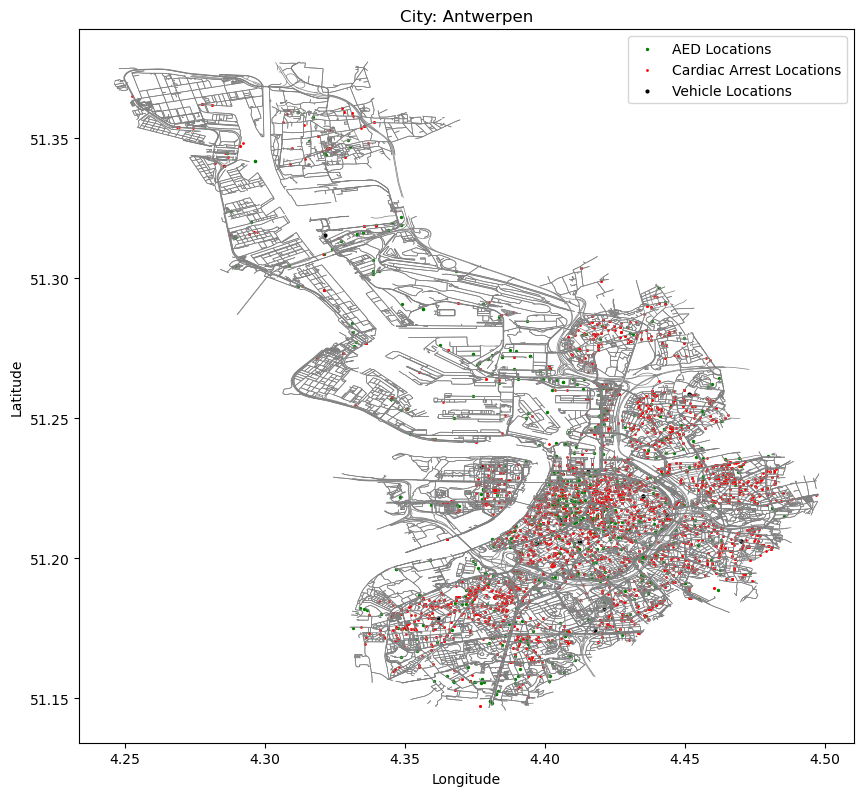

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


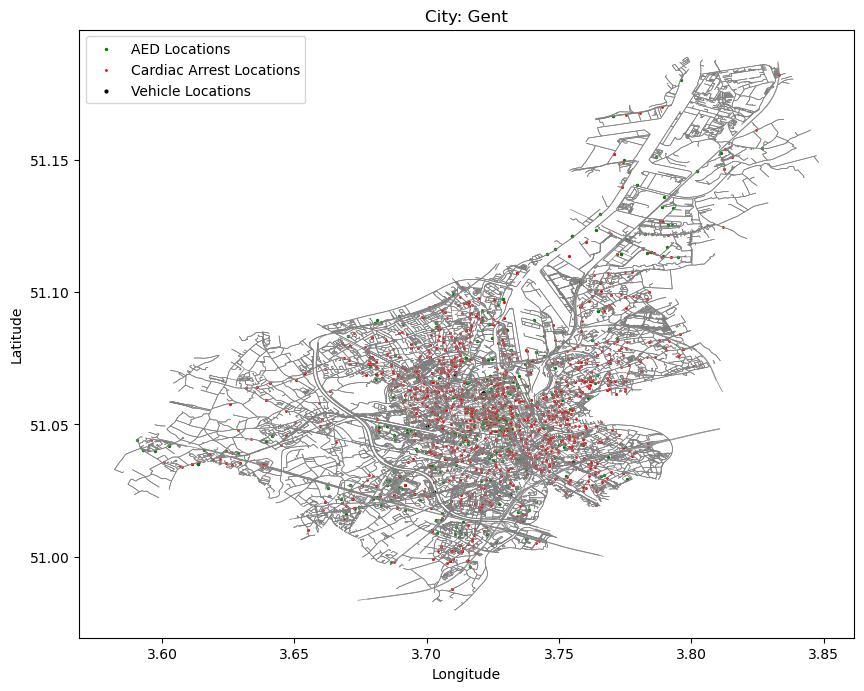

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


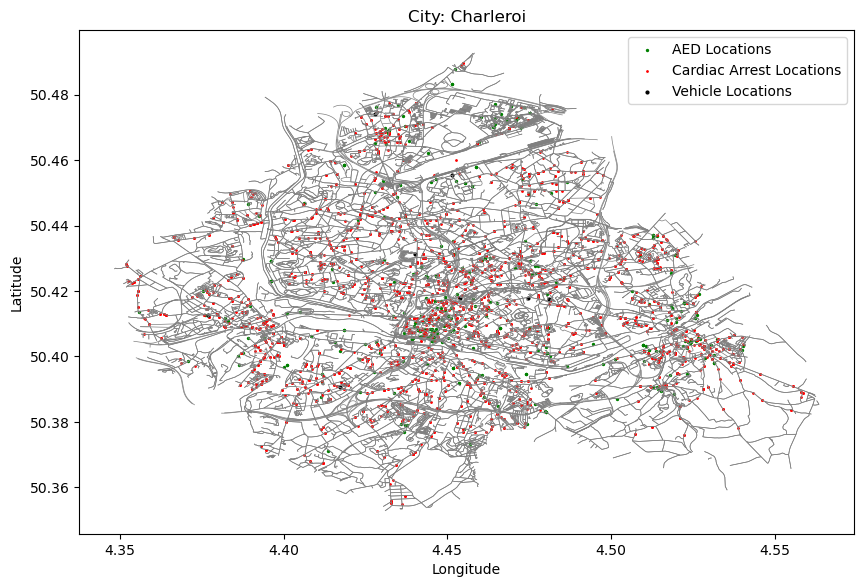

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


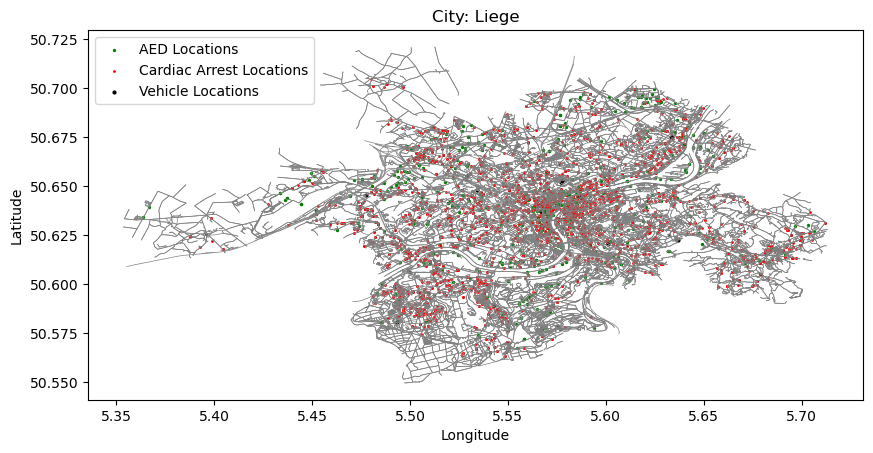

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


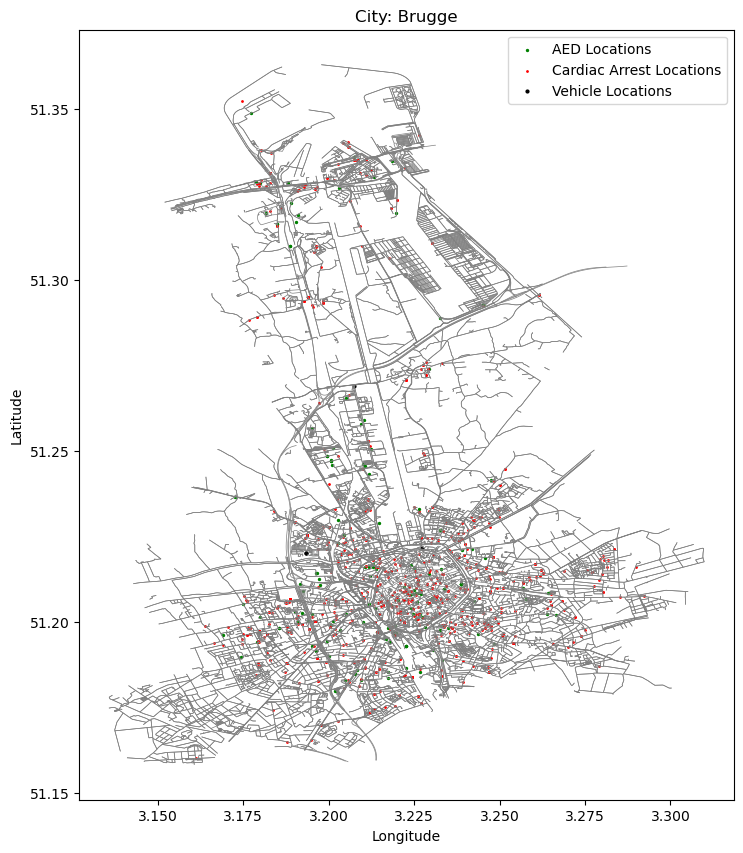

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


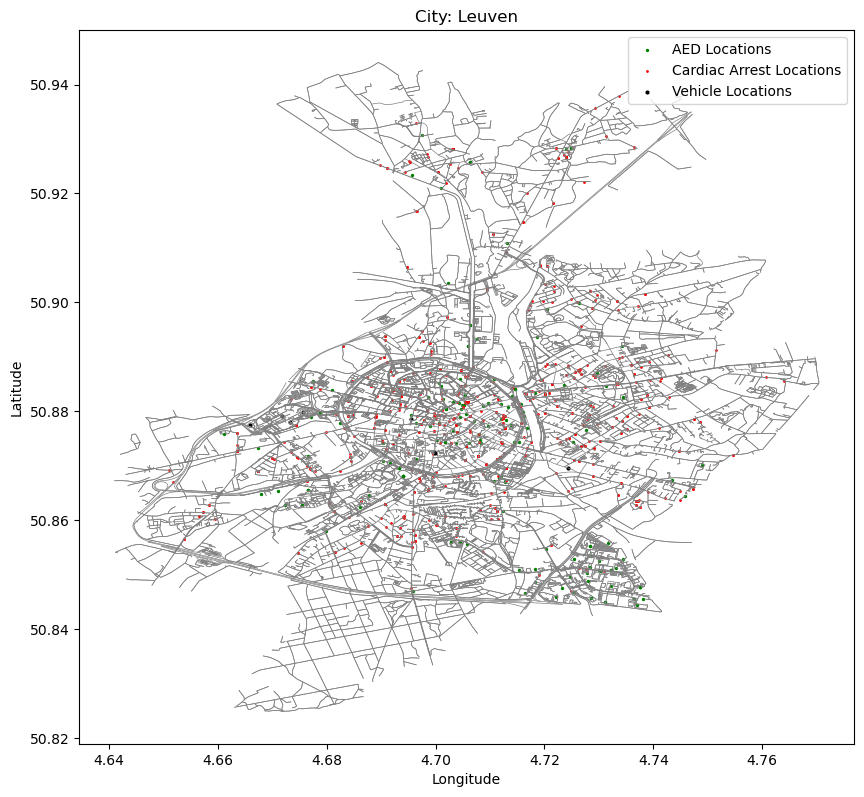

/var/folders/_7/5067xfmn3k19lcbv0zbwb5xm0000gn/T/ipykernel_30742/1803654507.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  streets = ox.graph_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], network_type='all')


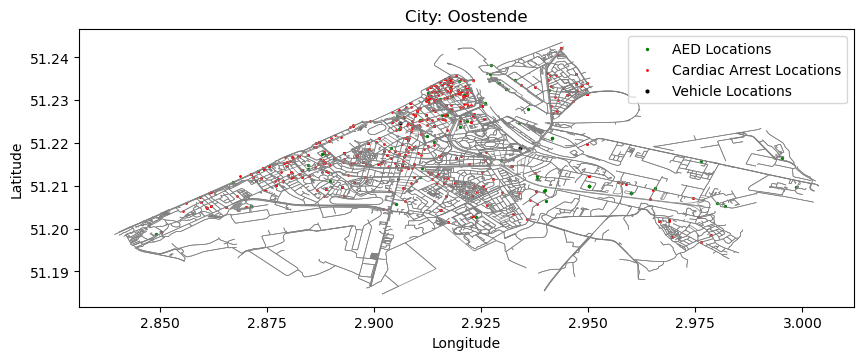

In [12]:
for city_name, city_polygon in cities[['CityName', 'geometry']].values:
    # Filter points within the city polygon
    city_aeds = filter_points_within_polygon(aeds, city_polygon)
    city_cards = filter_points_within_polygon(cards, city_polygon)
    city_vehicles = filter_points_within_polygon(vehicles, city_polygon)
    
    # Plot the streets
    fig, ax = plt.subplots(figsize=(10, 10))
    streets = get_streets_within_polygon(city_polygon)
    streets.plot(ax=ax, color='gray', linewidth=0.5)
    
    # Plot the AED locations
    if not city_aeds.empty:
        city_aeds.plot(ax=ax, color='green', markersize=2, label='AED Locations')
    
    # Plot the card locations
    if not city_cards.empty:
        city_cards.plot(ax=ax, color='red', markersize=1, label='Cardiac Arrest Locations')
    
    # Plot the vehicle locations
    if not city_vehicles.empty:
        city_vehicles.plot(ax=ax, color='black', markersize=4, label='Vehicle Locations')
    
    ax.set_title(f"City: {city_name}")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect(1)
    ax.legend()
    plt.show()

In [13]:
###Number of AED locations, too high
print(f'Brussels: {len(brussels_new_aeds)}')
print(f'Antwerp: {len(antwerpen_new_aeds)}')
print(f'Liege: {len(liege_new_aeds)}')
print(f'Bruge: {len(brugge_new_aeds)}')
print(f'Charleroi: {len(charleroi_new_aeds)}')
print(f'Leuven: {len(leuven_new_aeds)}')
print(f'Oostende: {len(oostende_new_aeds)}')
print(f'Gent: {len(gent_new_aeds)}')


Brussels: 5775
Antwerp: 2705
Liege: 2725
Bruge: 1723
Charleroi: 1437
Leuven: 1274
Oostende: 629
Gent: 2433
